In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import os

from matplotlib.lines import Line2D
from matplotlib.patches import Patch


import seaborn as sns
plt.style.use('ggplot')

In [2]:
import random

def rand_jitter(array):
    return([i+random.uniform(-1, 1)/10 for i in array])

In [3]:
def jaccard(a, b):
    return(len(set(a).intersection(b))/len(np.union1d(a, b)))

# Loading data 

In [4]:
lipid_path = 'data/lba_all_pixels_fully_abamapped11282023_exp_lipidclasses_allenannot.parquet'
lipids = pd.read_parquet(lipid_path)
non_lipid_columns = ['x_ccf','y_ccf', 'z_ccf', 'Section', 'x', 'y', 'acronym', 'id', 'name', 
                     'structure_id_path', 'structure_set_ids', 'rgb_triplet', 'allencolor']

lipids_s12 = lipids[lipids['Section']==12]
lip_s12=lipids_s12[[i for i in lipids_s12.columns if i not in non_lipid_columns]]

#Removing noisy lipids
std_dict = lip_s12[lip_s12>0.00011].std(axis = 0).to_dict()
selected_lipids = [i for i in std_dict.keys() if (std_dict[i]>0.00011)]
l_s12 = lip_s12[selected_lipids]


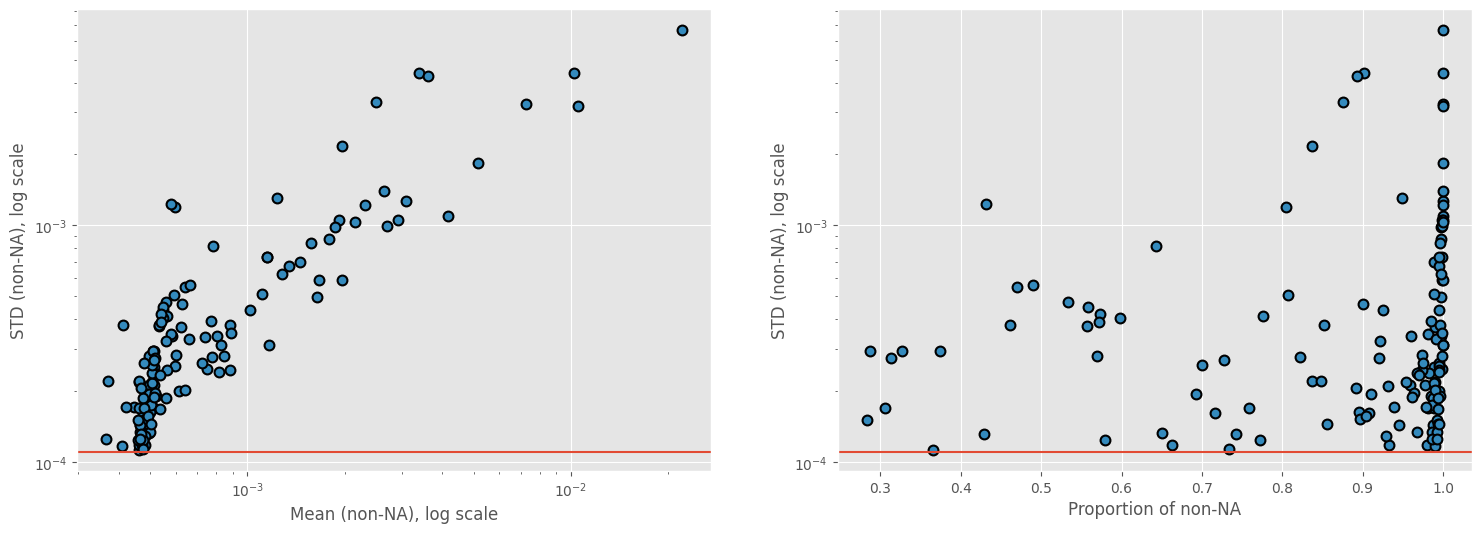

In [5]:
fig = plt.figure(figsize=(18, 6))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
x1 = l_s12[l_s12>0.00011].mean(axis = 0).values
x2 = (l_s12[l_s12>0.00011].count()/l_s12.shape[0]).values
y = l_s12[l_s12>0.00011].std(axis = 0).values


ax1.scatter(x1, y, c='C1', edgecolor='k', linewidth = 1.5, s = 50)
ax2.scatter(x2, y, c='C1', edgecolor='k', linewidth = 1.5, s = 50)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.axhline(0.00011)
ax2.set_yscale('log')
ax2.axhline(0.00011)
ax1.set_xlabel('Mean (non-NA), log scale')
ax1.set_ylabel('STD (non-NA), log scale')
ax2.set_xlabel('Proportion of non-NA')
ax2.set_ylabel('STD (non-NA), log scale')
plt.savefig('images/median_std_nacounts_OriginalData.pdf', bbox_inches='tight')
plt.show()

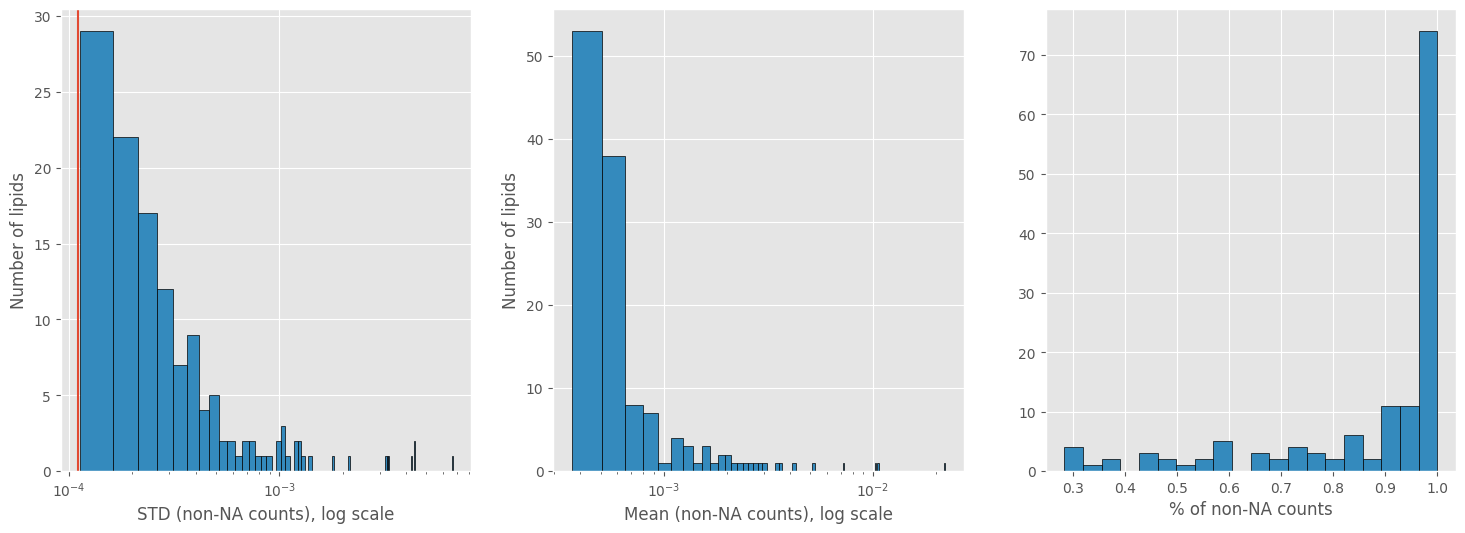

In [6]:
#Checking the distriburion of lipids values (std, mean and number of NAs)

fig = plt.figure(figsize=(18, 6))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)
ax1.hist(y, bins = 130, color = 'C1', edgecolor='black')
ax2.hist(x1, bins = 150, color = 'C1', edgecolor='black')
ax3.hist(x2, bins = 20, color = 'C1', edgecolor='black')
for ax in [ax1, ax2]: 
    ax.set_xscale('log')
    ax.set_ylabel('Number of lipids')
ax1.axvline(0.00011)
ax1.set_xlabel('STD (non-NA counts), log scale')
ax2.set_xlabel('Mean (non-NA counts), log scale')
ax3.set_xlabel('% of non-NA counts')
plt.savefig('images/hist_original_data_mesurments.pdf', bbox_inches='tight')
plt.show()

# Analysis of N number and strategy selected for aggregation


In [7]:
summary = pd.read_csv('results/PyCaret_summary.csv')

In [8]:
method_colors = {'catboost': '#fff100',
                  'xgboost': '#68217a',
                  'knn': '#009e49',
                  'ridge': '#ec008c',
                  'lr': '#ff8c00'}
data_cl = {'values':[], 'colors':[]}


data_g = {'values':[], 'colors':[]}
data_m = {'values':[], 'colors':[]}
data_n = {'values':[], 'colors':[]}

for n in ['closest','5', '10', '100', '1000','5000', '10000']:
    if(n=='closest'): #Extracting values for n='closest'
        summ = summary[summary['n']=='closest']
        for lipid in selected_lipids:
            res = summ[summ['lipid']==lipid].sort_values(by='R2', ascending=False).iloc[0]
            data_cl['values'].append(res['R2'])
            data_cl['colors'].append(method_colors[res['ML']])
        
    else: #extracting values for all other n   
        summ_n = summary[summary['n']==n]
        #Results per method
        for method, m_dict in zip(['gaussian', 'median', 'neglog'], [data_g, data_m, data_n]):
            summ = summ_n[summ_n['method']==method]
            vals = []
            cols = []
            for lipid in selected_lipids:
                res = summ[summ['lipid']==lipid].sort_values(by='R2', ascending=False).iloc[0]
                vals.append(res['R2'])
                cols.append(method_colors[res['ML']])
            m_dict['values'].append(vals)
            m_dict['colors'].append(cols)

    


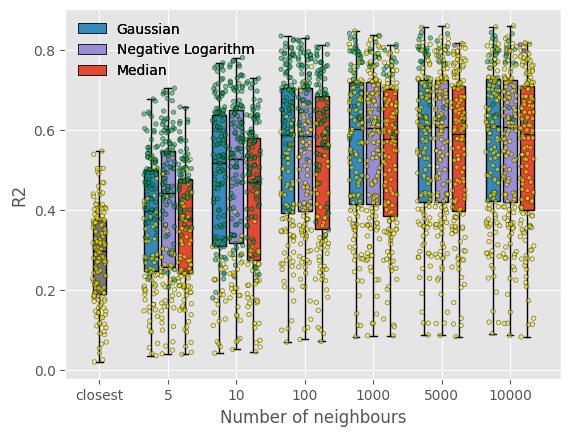

In [9]:

method_colors_ = {'CatBoost': '#fff100',
                  'XgBoost': '#68217a',
                  'KNN': '#009e49'}

legend_elements = [Patch(facecolor='C1', edgecolor='k',label='Gaussian'),
                   Patch(facecolor='C2', edgecolor='k',label='Negative Logarithm'),
                   Patch(facecolor='C0', edgecolor='k',label='Median')]
legend_elements2 = [Line2D([0], [0], marker='o', markerfacecolor=method_colors_[key], 
                           markeredgecolor='k', label=key, linestyle='') for key in method_colors_.keys()]

# Create the figure
fig, ax = plt.subplots()
ax.boxplot(data_cl['values'], widths=0.2, positions=[0], 
            patch_artist=True,
            boxprops=dict(facecolor='C3', color='k'), medianprops=dict(color='k'))

ax.scatter(rand_jitter([0 for k in range(len(selected_lipids))]),data_cl['values'], 
                 alpha = 0.5, s = 10, c = data_cl['colors'], edgecolor = 'k', 
                zorder = 100)

ax.boxplot(data_g['values'], widths=0.2, positions=[i - 0.25 for i in range(1, 7)], 
            patch_artist=True,
            boxprops=dict(facecolor='C1', color='k'), medianprops=dict(color='k'))

for i in range(1, 7):
    plt.scatter(rand_jitter([i-0.25 for k in range(len(selected_lipids))]),data_g['values'][i-1], 
                 alpha = 0.5, s = 10, c = data_g['colors'][i-1], edgecolor = 'k', 
                zorder = 100)
    
ax.boxplot(data_n['values'], widths=0.2, positions=[i for i in range(1, 7)], 
            patch_artist=True,
            boxprops=dict(facecolor='C2', color='k'), medianprops=dict(color='k'))
for i in range(1, 7):
    ax.scatter(rand_jitter([i for k in range(len(selected_lipids))]),data_n['values'][i-1], 
                 alpha = 0.5, s = 10, c = data_n['colors'][i-1], edgecolor = 'k', 
                zorder = 100)    
ax.boxplot(data_m['values'], widths=0.2, positions=[i + 0.25 for i in range(1, 7)], 
            patch_artist=True,
            boxprops=dict(facecolor='C0', color='k'), medianprops=dict(color='k'))
for i in range(1, 7):
    ax.scatter(rand_jitter([i+0.25 for k in range(len(selected_lipids))]),data_m['values'][i-1], 
                 alpha = 0.5, s = 10, c = data_m['colors'][i-1], edgecolor = 'k', 
                zorder = 100)

ax.set_xticks(range(7), labels = ['closest', '5', '10', '100', '1000', '5000', '10000'])
ax.set_xlabel('Number of neighbours')
ax.set_ylabel('R2')

legend2 = ax.legend(handles = legend_elements2, loc = 'center',
                    ncols=5, bbox_to_anchor=(0.5, -0.2, 0, 0),
                    fancybox=True, framealpha=0)
legend1 = ax.legend(handles=legend_elements, loc='best', fancybox=True, framealpha=0)

plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
plt.savefig('images/n_closest_analysis.pdf', bbox_inches='tight')
plt.show()


# Analysis of CatBoost Models and comparison to MLP

In [10]:
#Loading precomputed data. Let me know if you prefer absolutely raw data, not this aggregation of data
l_res = pd.read_csv('results/NL_n1000_perlipid.csv', index_col = 0)

#Setting some colors/names


l_col = ["#2f4f4f","#800000","#008000","#7f007f","#8fbc8f","#ff4500","#ffa500","#0000cd","#000000","#00fa9a",
         "#4169e1","#e9967a","#00bfff","#ff00ff","#ffff54","#dda0dd","#ff1493"]
lipids_types = list(set([i.split(' ')[0].split('(')[0] for i in selected_lipids]))
l_type_colors = {i[0]: i[1] for i in zip(lipids_types, l_col)}

l_cat_colors = {'Glycerophospholipids':"#008000", 
                'Sphingolipids':"#00bfff",
                'Other':'k'}

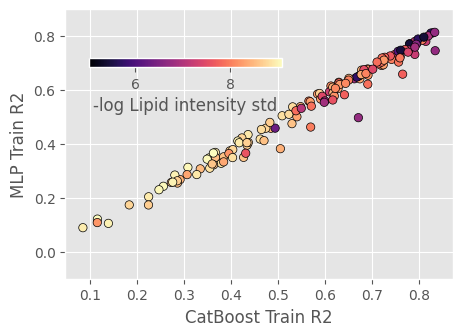

In [11]:
#Comparing NN and Catboost
plt.style.use('ggplot')
plt.figure(figsize = (5, 5))
plt.scatter(l_res['CatBoostResult'],
            l_res['MLP R2'],
            edgecolor = 'k', 
            c = -np.log(list(l_res['nonna_std'])), cmap = 'magma')
plt.ylim(-0.1, 0.9)
plt.xlabel('CatBoost Train R2')
plt.ylabel('MLP Train R2')
plt.colorbar(label = '-log Lipid intensity std', anchor = (0.12, 6.8),
            orientation = 'horizontal', shrink=0.5)
plt.savefig('images/Comparing_Catboost_NN_std.pdf', format='pdf', 
           bbox_inches='tight')
plt.show()

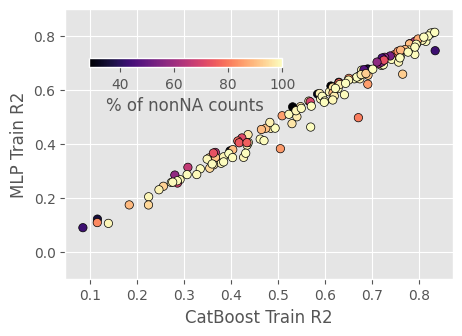

In [12]:
#Comparing NN and Catboost
plt.style.use('ggplot')
plt.figure(figsize = (5, 5))
plt.scatter(l_res['CatBoostResult'],
            l_res['MLP R2'],
            edgecolor = 'k', 
            c = list(l_res['na_composition']*100), cmap = 'magma')
plt.ylim(-0.1, 0.9)
plt.xlabel('CatBoost Train R2')
plt.ylabel('MLP Train R2')
plt.colorbar(label = '% of nonNA counts', anchor = (0.12, 6.8),
            orientation = 'horizontal', shrink=0.5)
plt.savefig('images/Comparing_Catboost_NN_nona.pdf', format='pdf', 
           bbox_inches='tight')
plt.show()

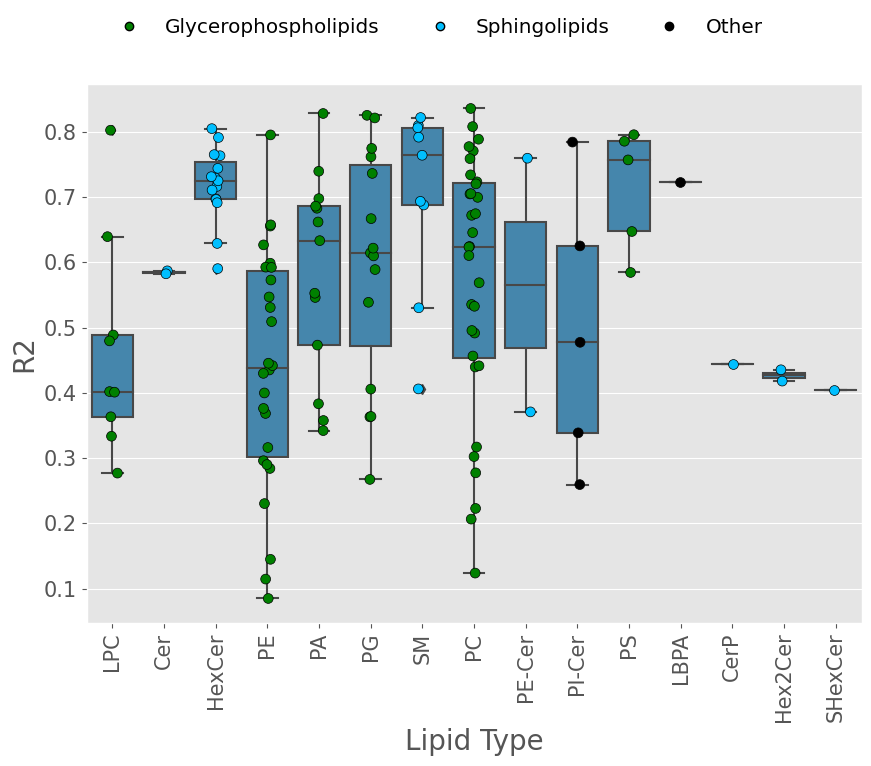

In [13]:
#Stratifying lipids per category
legend_elements = [Line2D([0], [0], marker='o', markerfacecolor=l_cat_colors[key], 
                           markeredgecolor='k', label=key, linestyle='') for key in l_cat_colors.keys()]


fig = plt.figure(figsize=(10, 7))

ax1 = plt.subplot(111)

ax1 = sns.boxplot(data = l_res, x = 'lipid_type', y = 'CatBoostFinal', ax = ax1, color = 'C1')
sns_labs = [t.get_text()  for t in ax1.get_xticklabels()]
ax1.set_xticklabels(sns_labs, rotation = 90, fontsize = 15)
ax1.tick_params(axis='both', labelsize=15)
ax1.set_xlabel('Lipid Type', fontsize = 20)
ax1.set_ylabel('R2', fontsize = 20)
    
for i, l_type in enumerate(sns_labs):
    tmp_df = l_res[l_res['lipid_type']==l_type]
    #color = [tmp_df.loc[i]['best_algorithm_color'] if(tmp_df.loc[i]['low_impact']==False) else 'k' for i in tmp_df.index]
    jit = rand_jitter([i for k in range(tmp_df.shape[0])])
    ax1.scatter(jit, tmp_df['CatBoostFinal'],alpha = 1, s = 50, 
                edgecolor = 'k', zorder = 1000,
                c = list(tmp_df['lipid_category_color']))

fig.legend(handles=legend_elements, fancybox=True, framealpha=0, ncols = 4, loc = 'upper center', 
           fontsize = 'x-large')
plt.savefig('images/Lipid_groups_stratification.pdf', format='pdf', 
           bbox_inches='tight')
plt.show()

# Importances analysis

In [14]:
importances=pd.read_csv('results/importances.csv', index_col = 0)

In [15]:
genes_50 = {}
for lipid in selected_lipids:
    imp = importances.loc[lipid].sort_values(ascending=False)
    for i in range(500):
        if imp[:i+1].sum()>50:
            genes_50[lipid] = imp.index[:i+1]
            break
            
genes_jaccard = []
for lipid1 in selected_lipids:
    r = []
    genes1 = genes_50[lipid1]
    for lipid2 in selected_lipids:
        genes2 = genes_50[lipid2]
        r.append(jaccard(genes1, genes2))
    genes_jaccard.append(r)

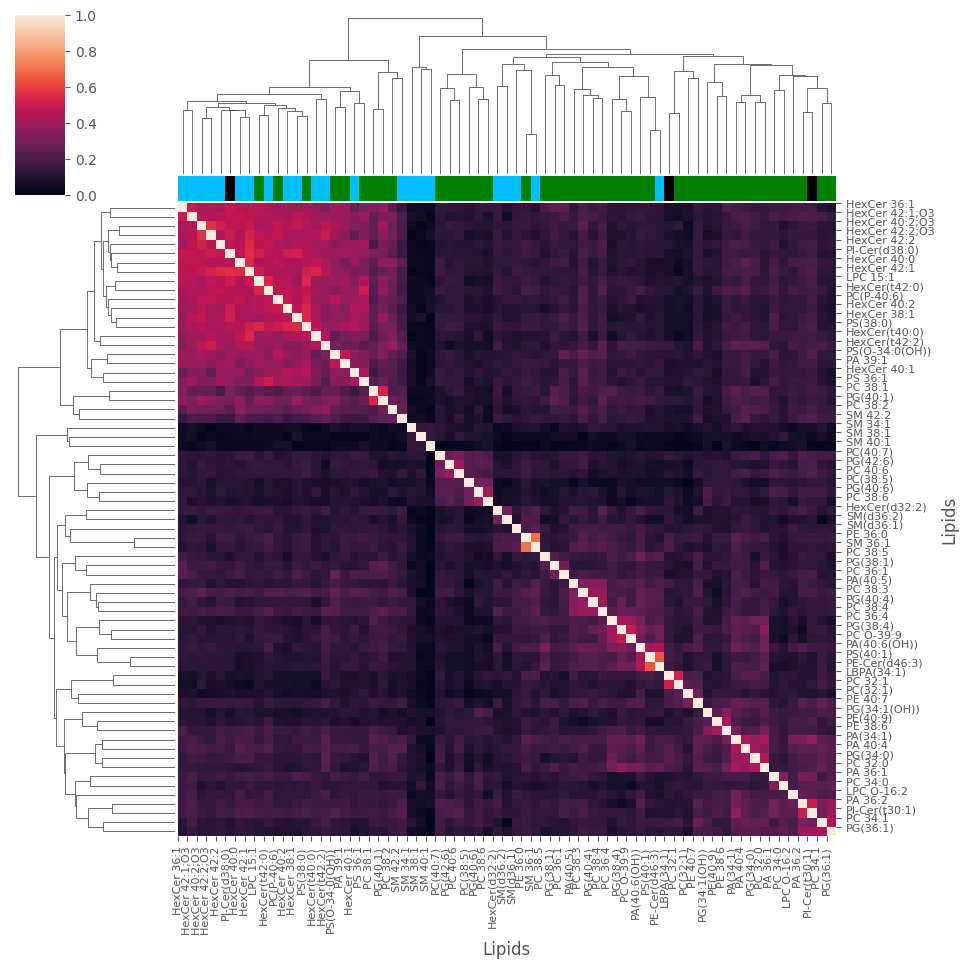

In [16]:
genes_jaccard = pd.DataFrame(genes_jaccard, columns = l_res.index, 
                             index = l_res.index)
selection = list(l_res[l_res['CatBoostFinal']>0.6].index)
#Further analysis is performed for lipids with R2 > 0.6. If you want to do it for all lipids, uncomment the 
#next line

#selection = list(l_res['lipid_name'])
plot_data = genes_jaccard[selection].loc[selection]
if(plot_data.shape[0]>70): fs=4
else: fs = 8
g = sns.clustermap(plot_data, col_colors= list(l_res.loc[selection]['lipid_category_color']), 
               method = 'average')
g.ax_heatmap.set_xlabel('Lipids')
g.ax_heatmap.set_ylabel('Lipids')
g.ax_heatmap.set_xticks([i for i in range(len(selection))])
g.ax_heatmap.set_xticklabels([plot_data.columns[i] for i in g.dendrogram_row.reordered_ind],
                             rotation = 90, fontsize = fs)

g.ax_heatmap.set_yticks([i for i in range(len(selection))])
g.ax_heatmap.set_yticklabels([plot_data.columns[i] for i in g.dendrogram_row.reordered_ind],
                             fontsize = fs)
plt.savefig('images/Jaccard_06.pdf', format='pdf', 
           bbox_inches='tight')
plt.show()

/home/jules/miniconda3/envs/ml-project-2-genelipids-cpu/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


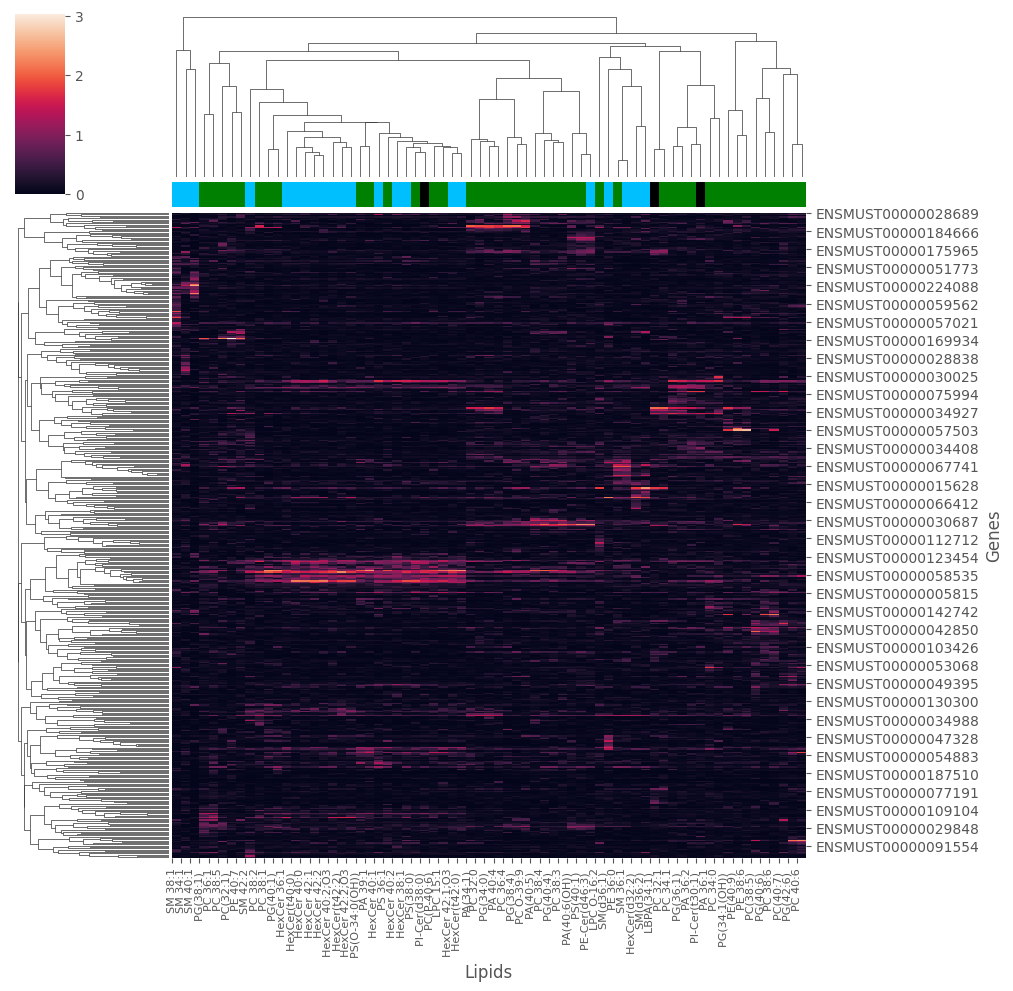

In [17]:
selection2 = list(l_res[l_res['CatBoostFinal']>0.6]['alternative_name'])
plot_data = importances.loc[selection2]
g = sns.clustermap(np.log1p(plot_data.T), metric = 'correlation', 
               method = 'weighted', 
               col_colors= list(l_res['lipid_category_color'].loc[selection]))


if(plot_data.shape[0]>70): fs=4
else: fs = 8

g.ax_heatmap.set_xlabel('Lipids')
g.ax_heatmap.set_ylabel('Genes')
g.ax_heatmap.set_xticks([i for i in range(len(selection))])
g.ax_heatmap.set_xticklabels([plot_data.T.columns[i] for i in g.dendrogram_col.reordered_ind],
                             rotation = 90, fontsize = fs)
plt.savefig('images/Correlation_06.pdf', format='pdf', 
           bbox_inches='tight')
plt.show()

# Residual analysis

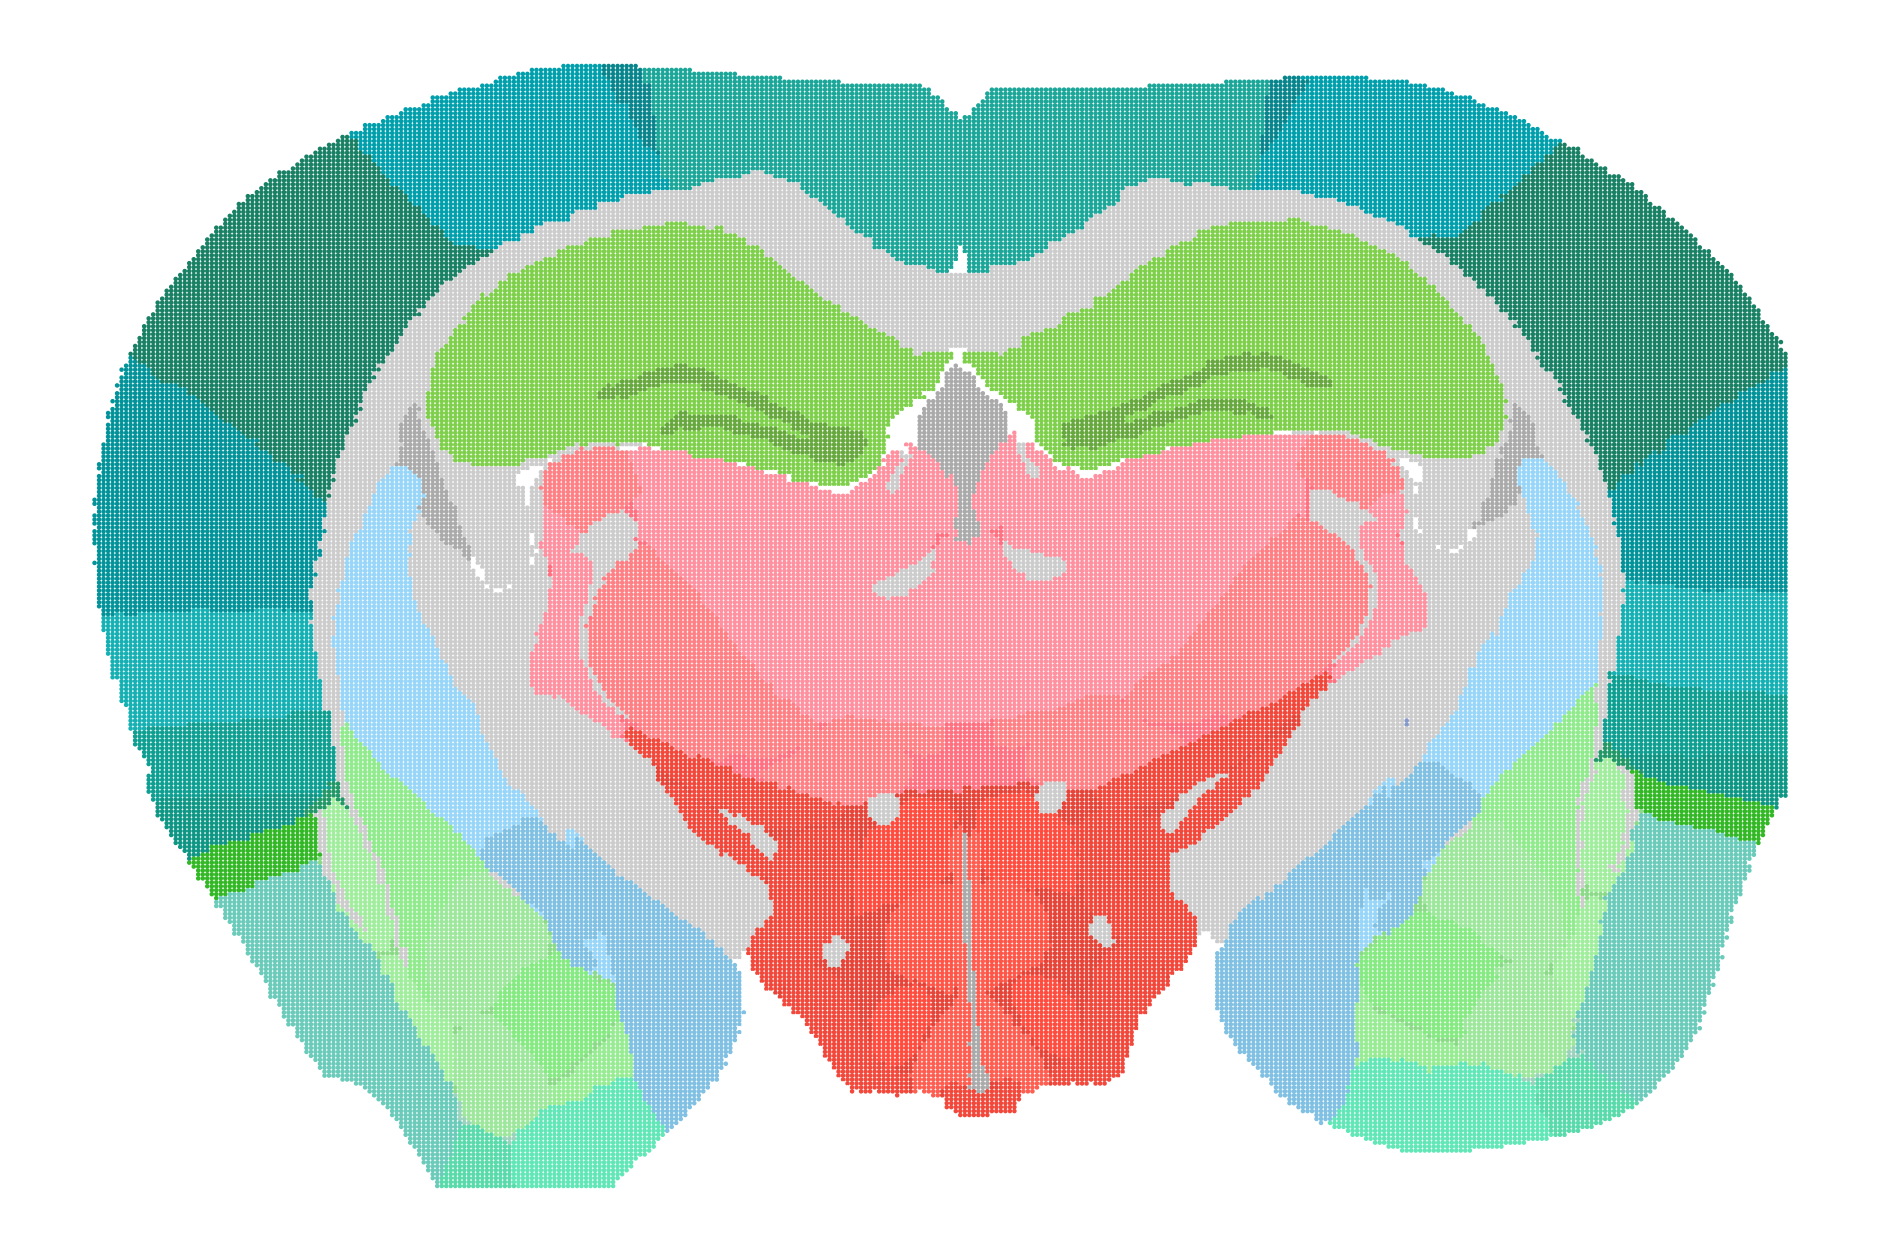

In [18]:
plt.figure(figsize=(24, 16))

dot_size = 0.1
plt.style.use('default')
plt.scatter(lipids_s12['y'], -lipids_s12['x'], s = 5, c = lipids_s12['allencolor'])
plt.axis('off')

plt.savefig('images/R2_analysis_A.pdf', format='pdf', 
           bbox_inches='tight')
plt.show()

In [19]:
lipids_names_all = [i for i in lipids.columns if i not in non_lipid_columns]

prediction = pd.read_csv('results/catboost_predictions/0_prediction.csv', 
                                index_col = 0)
zone_pixel = {zone:[] for zone in set(lipids_s12['allencolor'])}
for pixel in prediction.index:
    zone_pixel[lipids_s12.loc[lipids_s12.index[pixel]]['allencolor']].append(pixel)

In [20]:
#This might take some time
lipid_zone_stat_balanced = {}
for i, lipid in enumerate(lipids_names_all):
    #if(lipid in selected_lipids):
        l_z_stat = []
        prediction_df = pd.read_csv('results/catboost_predictions/{0}_prediction.csv'.format(str(i)), 
                                    index_col = 0)
        mean = prediction_df[str(i)].mean()
        resigual_coef = (prediction_df['prediction_label'] - prediction_df[str(i)])**2
        residual_compl = resigual_coef.sum()/((prediction_df[str(i)]-mean)**2).sum()
        for zone in zone_pixel.keys():
            #print(zone)
            pr_df = prediction_df.loc[zone_pixel[zone]]/residual_compl
            coef = ((pr_df['prediction_label'] - pr_df[str(i)])**2)
            r_partial = coef.sum()/(((prediction_df[str(i)]-mean)**2).sum()*pr_df.shape[0]) 
            if(r_partial>1): print(l, zone)
            l_z_stat.append(r_partial)
        lipid_zone_stat_balanced[lipid] = l_z_stat
        
        print(lipid)

LPC O- 18:3
LPC 15:1
LPC O-18:3
LPC 20:4
Cer 36:1
LPC 22:6
Cer 40:2
Cer 42:2
PE(30:1) 
HexCer(d32:2) 
PE(32:1) 
PA(34:1)
PG(30:1) 
PE 34:2
PA(P-38:6) 
PA 36:4
PA(36:3) 
PI-Cer(t30:2) 
PA 36:2
PE O-34:2
PA 36:1
SM 34:1
PE(O-34:1) 
PC(30:0) 
PG 32:0
PC 33:1
PC 33:0
SM(d36:1) 
PC(32:1) 
PE-Cer(d38:1) 
PE 34:1
PC 34:2
PA 38:3
PI-Cer(t32:2) 
PE(36:2) 
PS(O-34:0(OH)) 
SM(d36:2) 
PA 39:1
PE O-36:2
HexCer 36:0
PA(38:1) 
PE 36:0
LBPA(34:1) 
PG(34:0) 
PA 40:4
PC 35:0
PE 36:3
PE 36:2
HexCer 36:1
HexCer 40:2
PE O-39:7
CerP(t42:1) 
PE O-39:6
PE(36:0) 
PC 36:2
PA 40:6
PA(40:6(OH)) 
PA(40:5) 
PE 37:2
PE 40:4
SM 38:1
PC 34.1
PG(36:1) 
PE O-40:6
PC 37:1
PG(34:1(OH)) 
PA 42:4
PC 36.2
HexCer 40:0
PC 35:2
HexCer 38:1
PA(42:8) 
PE(40:7) 
PA 42:7
PE(P-40:6) 
PE(O-40:6) 
PE O-41:11
PE(42:6) 
PS(38:0) 
PG(38:4) 
PC O-39:9
PC 36:3
HexCer 40:1
PG(38:3) 
PE(40:9) 
PE O-42:8
PG(38:2) 
SM 40:1
PE(40:8) 
PG(38:1) 
PE 40:7
PS 36:1
PC 38:5
PE(40:4) 
Hex2Cer 32:1
HexCer 40:2;O3
PI-Cer(d38:0) 
PC(P-40:6) 
HexCer(t40:0)

In [21]:
lipid_zone_stat_balanced = np.asarray([lipid_zone_stat_balanced[lip] for lip in lipids_names_all])
# Analysing only good performing lipids (R2 > 0.6)
#change the number bellow to 0 if you want analysis of all lipids, not only good performing one
sel = [lipids_names_all.index(i) for i in l_res[l_res['CatBoostFinal']>0.6]['alternative_name']]
#Analysing only zone where number of dots >100, 
#change the number bellow to 0 if you want analysis of all lipids, not only good performing one
sel_zone = []
for i, col in enumerate(list(zone_pixel.keys())):
    if(len(zone_pixel[col])>100): sel_zone.append(i)

<Figure size 2400x3200 with 0 Axes>

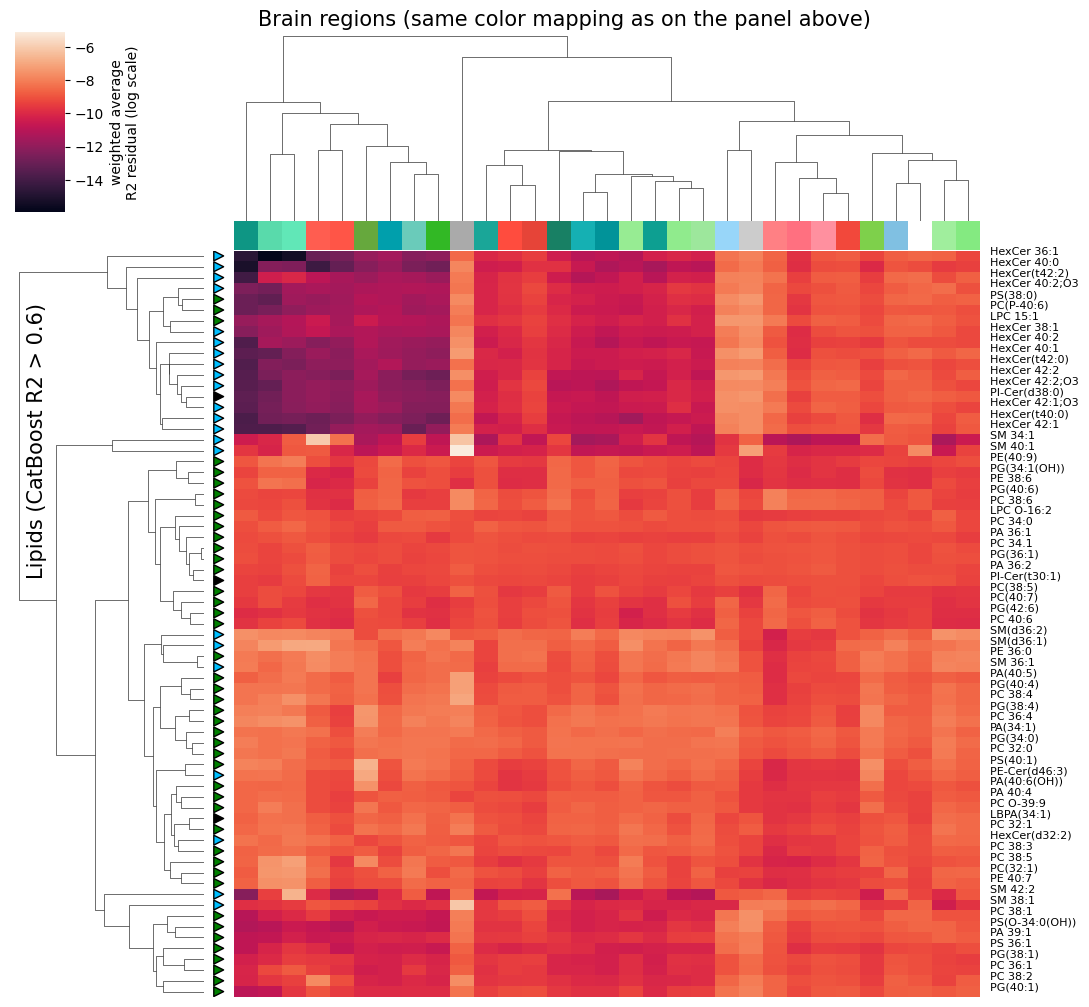

In [22]:
cols = np.asarray(l_res[l_res['CatBoostFinal']>0.6]['lipid_category_color'])
plt.figure(figsize=(24, 32))


plot_data = pd.DataFrame(lipid_zone_stat_balanced[sel][:, sel_zone],
             index = [lipids_names_all[i] for i in sel])
g = sns.clustermap(np.log(plot_data), 
                   col_colors=np.asarray(list(zone_pixel.keys()))[sel_zone],
                   row_colors=['w' for i in cols],
                   yticklabels=False,xticklabels=False)
g.ax_heatmap.tick_params(right=False, bottom=False)
g.ax_row_dendrogram.text(10.5, 300, 'Lipids (CatBoost R2 > 0.6)', rotation=90, fontsize = 15)

rd = g.ax_row_dendrogram
rc = g.ax_row_colors
rc.clear()
rc.patch.set_facecolor('w')
rc.axis('off')
rc.set_ylim(0.5,69.5)


rc.scatter([-1 for i in cols], [69-i for i in range(69)], 
           c = cols[g.dendrogram_row.reordered_ind], edgecolor = 'k', 
           zorder = 5000, s = 50, marker = '>')

g.ax_col_dendrogram.text(10, 14, 'Brain regions (same color mapping as on the panel above)', 
                         fontsize = 15)
g.ax_heatmap.set_yticks([i for i in range(len(sel))])
g.ax_heatmap.set_yticklabels([plot_data.index[i] for i in g.dendrogram_row.reordered_ind],
                             fontsize = 8)



plt.ylabel('weighted average\nR2 residual (log scale)')

plt.savefig('images/R2_analysis_B.pdf', format='pdf', 
           bbox_inches='tight')
plt.show()